In [ ]:
%%capture

!pip install moviepy

!pip3 install imageio==2.4.1

!pip install --upgrade imageio-ffmpeg
!pip install pafy youtube-dl
!pip install pytube
!pip install moviepy

In [ ]:
#importing libraries
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.backend import dropout
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, SimpleRNN, Dense, Flatten, Dropout, TimeDistributed

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
%%capture
!wget --no-check-certificate https://www.crcv.ucf.edu./data/UCF50.rar
!unrar x UCF50.rar

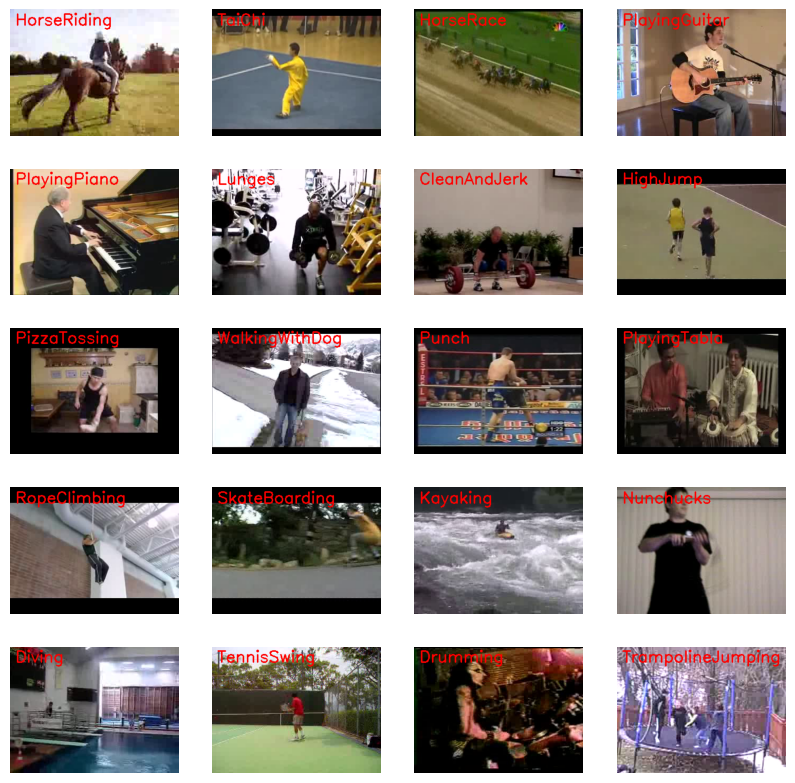

In [ ]:
plt.figure(figsize=(10,10))
all_classes_name = os.listdir('/content/drive/MyDrive/FYP Studies/UCF50')
random_range = random.sample(range(len(all_classes_name)), 20) #start, 50, 20
for counter, random_index in enumerate(random_range, 1):
  selected_class_name = all_classes_name[random_index]
  video_files_name_list = os.listdir(f'/content/drive/MyDrive/FYP Studies/UCF50/{selected_class_name}')
  selected_video_file_name = random.choice(video_files_name_list)
  video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/FYP Studies/UCF50/{selected_class_name}/{selected_video_file_name}')
  _, bgr_frame = video_reader.read()
  video_reader.release()
  #converting bgr to rgb
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
  plt.subplot(5,4,counter); plt.imshow(rgb_frame); plt.axis('off')



In [ ]:
#Data Preprocessing
image_height, image_width = 64,64
sequence_length = 20
dataset_dir = '/content/drive/MyDrive/FYP Studies/UCF50'
classes_list = ['WalkingWithDog', 'TaiChi', 'Swing', 'HorseRace']

In [ ]:
#define a function to extract frames equally which gives equally distributed frames not the whole
def frames_extractions(video_path):
  frames_list = []
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/sequence_length),1)

  for frame_counter in range(sequence_length):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter*skip_frames_window)
    success, frame = video_reader.read()
    if not success:
      break
    resized_frame = cv2.resize(frame, (image_height, image_width))
    normalized_frame = resized_frame/255
    frames_list.append(normalized_frame)
  video_reader.release()
  return frames_list

In [ ]:
def create_dataset():
  features =[]
  labels = []
  video_files_paths = []
  for class_index, class_name in enumerate(classes_list):
    print(f'extracting data of class {class_name}')
    files_list = os.listdir(os.path.join(dataset_dir,class_name))
    for file_name in files_list:
      video_file_path = os.path.join(dataset_dir, class_name, file_name)
      frames=frames_extractions(video_path=video_file_path)
      if len(frames)==sequence_length:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)
  features = np.asarray(features)
  labels = np.array(labels)
  return features, labels, video_files_paths

In [ ]:
data, lbl, paths = create_dataset()

extracting data of class WalkingWithDog
extracting data of class TaiChi
extracting data of class Swing
extracting data of class HorseRace


In [ ]:
data.shape

(487, 20, 64, 64, 3)

In [ ]:
# plt.figure(figsize=(10,10))
# for i in range(len(data)):
#   plt.subplot(30,20,i+1)
#   plt.axis('off')
#   plt.imshow(data[i][0]);
# plt.tight_layout()

In [ ]:
path = f'{dataset_dir}/{selected_class_name}/{selected_video_file_name}'
frames = frames_extractions(path)

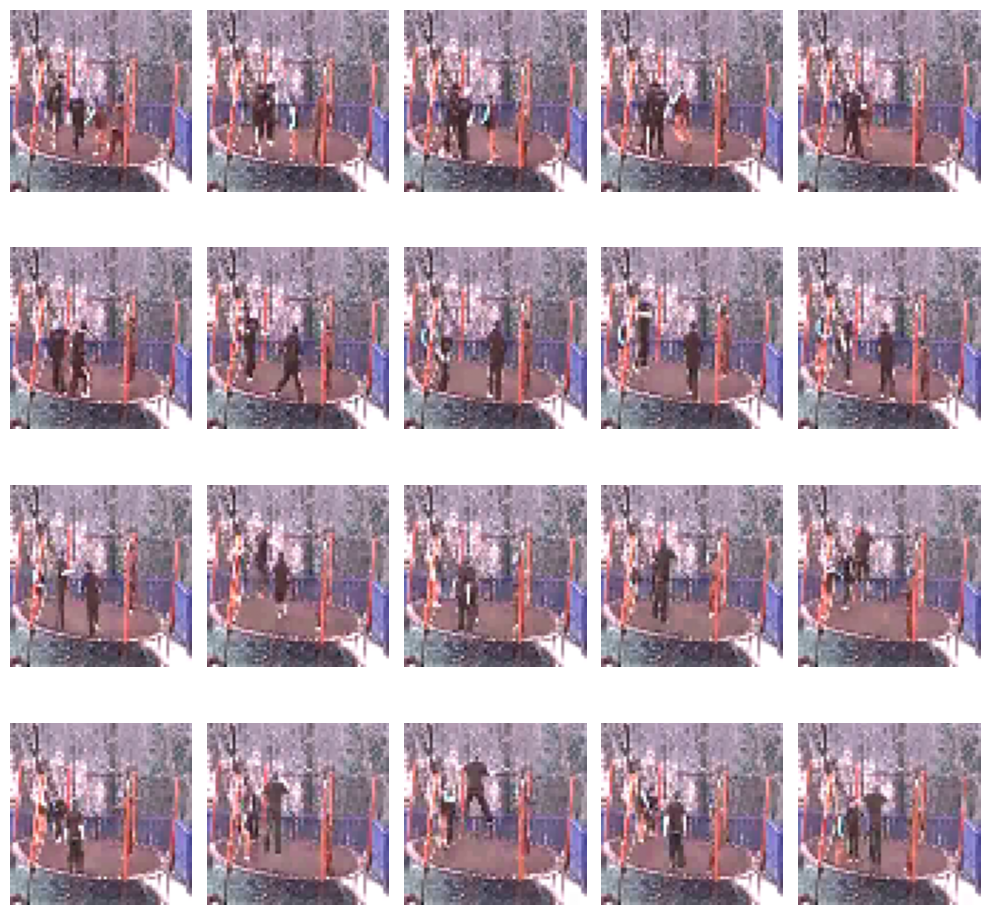

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(frames)):
  plt.subplot(4,5,i+1)
  plt.axis('off')
  plt.imshow(frames[i],'gray');
plt.tight_layout()

In [ ]:
#geting dataset
features, labels, video_files_paths = create_dataset()

extracting data of class WalkingWithDog
extracting data of class TaiChi
extracting data of class Swing
extracting data of class HorseRace


In [ ]:
#now converting labels to onehot encoding.
one_hot_encoded_labels = to_categorical(labels)
one_hot_encoded_labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
#splitting the data into train and test set
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.25,random_state=seed_constant, shuffle=True)
print(f'Train features has:\n\t{features_train.shape}\nTrain Labels has:\n\t{labels_train.shape}')

Train features has:
	(365, 20, 64, 64, 3)
Train Labels has:
	(365, 4)


# 3D CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout

input_shape = (20, 64, 64, 3)
model = Sequential()

# Add the first 3D convolutional layer with 64 filters, a kernel size of (3, 3, 3), and 'relu' activation
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Add additional convolutional and pooling layers for feature extraction
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# Flatten the output to feed into a dense layer
model.add(Flatten())

# Add a dense layer with dropout for regularization
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Add the output layer with appropriate activation for your activity classes
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 62, 62, 64)    5248      
                                                                 
 max_pooling3d (MaxPooling3  (None, 9, 31, 31, 64)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 29, 29, 128)    221312    
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 3, 14, 14, 128)    0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 12, 12, 256)    884992    
                                                                 
 flatten (Flatten)           (None, 36864)             0

In [ ]:
hist = model.fit(x=features_train, y=labels_train, epochs=50, batch_size=4,
                                          shuffle=True, validation_split=0.2)

Epoch 1/50
73/73 [==============================] - 10s 46ms/step - loss: 1.5797 - accuracy: 0.2808 - val_loss: 1.2491 - val_accuracy: 0.3562
Epoch 2/50
73/73 [==============================] - 3s 34ms/step - loss: 1.2683 - accuracy: 0.3870 - val_loss: 1.0666 - val_accuracy: 0.4795
Epoch 3/50
73/73 [==============================] - 2s 33ms/step - loss: 1.1620 - accuracy: 0.4863 - val_loss: 0.8651 - val_accuracy: 0.6712
Epoch 4/50
73/73 [==============================] - 2s 33ms/step - loss: 1.0224 - accuracy: 0.5959 - val_loss: 0.9834 - val_accuracy: 0.5068
Epoch 5/50
73/73 [==============================] - 2s 34ms/step - loss: 0.9287 - accuracy: 0.6199 - val_loss: 0.8392 - val_accuracy: 0.6301
Epoch 6/50
73/73 [==============================] - 3s 36ms/step - loss: 0.8787 - accuracy: 0.6404 - val_loss: 0.6086 - val_accuracy: 0.7397
Epoch 7/50
73/73 [==============================] - 3s 34ms/step - loss: 0.7493 - accuracy: 0.7021 - val_loss: 0.7396 - val_accuracy: 0.6712
Epoch 8/50
7

In [ ]:
model_evaluation = model.evaluate(x=features_test, y=labels_test)

# Print the evaluation results
print("Test Loss:", model_evaluation[0])
print("Test Accuracy:", model_evaluation[1])


4/4 [==============================] - 2s 249ms/step - loss: 2.8468 - accuracy: 0.6967
Test Loss: 2.8467676639556885
Test Accuracy: 0.6967213153839111


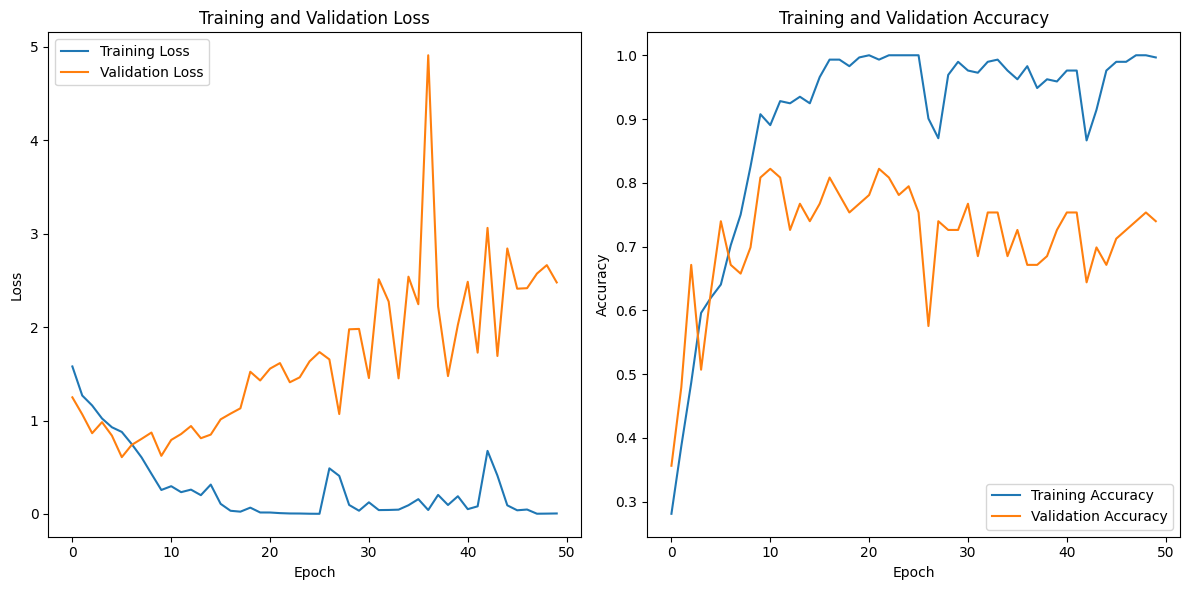

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def create_cnn_rnn_model(sequence_length, image_height, image_width, classes_list):
    model = Sequential()

    # CNN part
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(sequence_length, image_height, image_width, 3)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    # model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    # model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(256, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    # RNN part (SimpleRNN)
    model.add(TimeDistributed(Flatten()))
    model.add(SimpleRNN(64, return_sequences=False))  # Set return_sequences to False

    # Dense layers
    model.add(Flatten())
    model.add(Dense(len(classes_list), activation='softmax'))

    model.summary()
    return model


def create_convlstm_model():
  model = Sequential()
  model.add(ConvLSTM2D(filters=4, kernel_size=(3,3), activation='tanh', data_format='channels_last',
                       recurrent_dropout=0.2, return_sequences=True, input_shape=(sequence_length,image_height, image_width,3)))
  model.add(MaxPooling3D(pool_size=(1,2,2,), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=8, kernel_size=(3,3), activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=14, kernel_size=(3,3), activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=16, kernel_size=(3,3), activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(Flatten())
  model.add(Dense(len(classes_list), activation='softmax'))

  model.summary()
  return model


In [ ]:
#create CNNRNN Model
# image_height, image_width = 64,64
# sequence_length = 20
# classes_list
cnn_rnn_model = create_cnn_rnn_model(sequence_length, image_height, image_width, classes_list)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 62, 62, 32)    896       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 31, 31, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 29, 29, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 14, 14, 64)    0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 12, 12, 128)  

In [ ]:
# Your list of classes
classes_list = ['WalkingWithDog', 'TaiChi', 'Swing', 'HorseRace']

# Set your sequence length, image height, and image width accordingly
sequence_length = 20
image_height = 64
image_width = 64

In [ ]:
# Early stopping callback
# early_stopping_callbacks = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, mode='min')
# Compile the model
cnn_rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Training the model
cnn_rnn_model_history = cnn_rnn_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=4,
                                          shuffle=True, validation_split=0.2)

Epoch 1/50
73/73 [==============================] - 7s 35ms/step - loss: 1.4850 - accuracy: 0.2740 - val_loss: 1.3540 - val_accuracy: 0.3562
Epoch 2/50
73/73 [==============================] - 2s 26ms/step - loss: 1.3993 - accuracy: 0.2945 - val_loss: 1.3685 - val_accuracy: 0.3151
Epoch 3/50
73/73 [==============================] - 2s 32ms/step - loss: 1.3673 - accuracy: 0.3356 - val_loss: 1.3176 - val_accuracy: 0.4247
Epoch 4/50
73/73 [==============================] - 3s 38ms/step - loss: 1.2229 - accuracy: 0.4384 - val_loss: 1.1783 - val_accuracy: 0.3836
Epoch 5/50
73/73 [==============================] - 2s 25ms/step - loss: 1.1285 - accuracy: 0.4932 - val_loss: 1.0488 - val_accuracy: 0.5753
Epoch 6/50
73/73 [==============================] - 2s 25ms/step - loss: 0.9813 - accuracy: 0.5548 - val_loss: 0.9909 - val_accuracy: 0.6164
Epoch 7/50
73/73 [==============================] - 2s 25ms/step - loss: 0.8803 - accuracy: 0.6130 - val_loss: 0.8972 - val_accuracy: 0.6301
Epoch 8/50
73

In [ ]:
model_evaluation = cnn_rnn_model.evaluate(x=features_test, y=labels_test)

# Print the evaluation results
print("Test Loss:", model_evaluation[0])
print("Test Accuracy:", model_evaluation[1])


4/4 [==============================] - 2s 244ms/step - loss: 1.0259 - accuracy: 0.7869
Test Loss: 1.0259002447128296
Test Accuracy: 0.7868852615356445


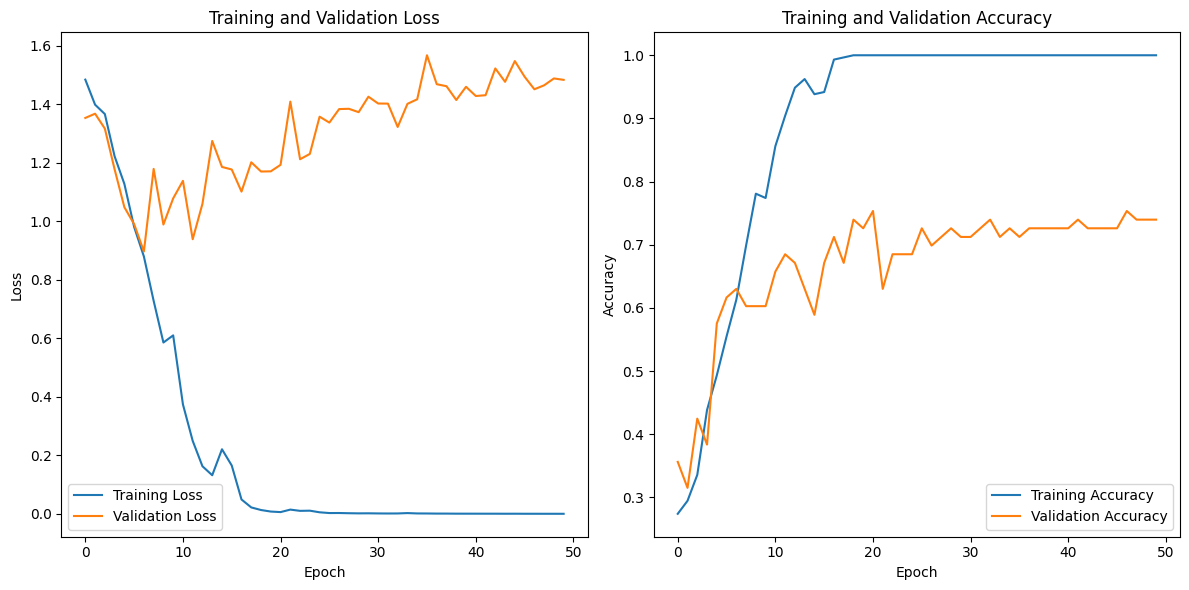

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_rnn_model_history.history['loss'], label='Training Loss')
plt.plot(cnn_rnn_model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_rnn_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_rnn_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
convlstm_model = create_convlstm_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 20, 31, 31, 4)     0         
 g3D)                                                            
                                                                 
 time_distributed_11 (TimeD  (None, 20, 31, 31, 4)     0         
 istributed)                                                     
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                      

In [ ]:
# plot_model(convlstm_model, to_file='/content/drive/MyDrive/FYP Studies/experiment1.png', show_shapes=True)

In [ ]:
early_stopping_callbacks = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, mode='min')
convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
convlstm_model_history = convlstm_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=4,
                                            shuffle=True, validation_split=0.2, callbacks=[early_stopping_callbacks])

Epoch 1/50
73/73 [==============================] - 35s 244ms/step - loss: 1.3605 - accuracy: 0.3596 - val_loss: 1.3158 - val_accuracy: 0.4932
Epoch 2/50
73/73 [==============================] - 17s 230ms/step - loss: 1.2714 - accuracy: 0.4315 - val_loss: 1.2190 - val_accuracy: 0.4658
Epoch 3/50
73/73 [==============================] - 18s 250ms/step - loss: 1.0936 - accuracy: 0.5514 - val_loss: 0.9431 - val_accuracy: 0.5890
Epoch 4/50
73/73 [==============================] - 18s 247ms/step - loss: 0.9496 - accuracy: 0.6027 - val_loss: 0.8981 - val_accuracy: 0.5616
Epoch 5/50
73/73 [==============================] - 16s 224ms/step - loss: 0.8081 - accuracy: 0.6644 - val_loss: 0.7391 - val_accuracy: 0.6301
Epoch 6/50
73/73 [==============================] - 20s 268ms/step - loss: 0.6087 - accuracy: 0.7705 - val_loss: 0.7295 - val_accuracy: 0.6986
Epoch 7/50
73/73 [==============================] - 16s 226ms/step - loss: 0.5182 - accuracy: 0.7979 - val_loss: 0.6004 - val_accuracy: 0.7534

In [ ]:
model_evaluation_history = convlstm_model.evaluate(x=features_test, y=labels_test)

4/4 [==============================] - 1s 164ms/step - loss: 0.7981 - accuracy: 0.7459


In [ ]:
#saving the model
from time import strftime
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
date_time_format = '%d_%m_%Y_%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time = strftime(date_time_format)
model_file_name = f'Convlst_model__date_time_{current_date_time}__loss_{model_evaluation_loss*100:.2f}%__accuracy_{model_evaluation_accuracy*100:.2f}%.h5'
convlstm_model.save('/content/drive/MyDrive/FYP Studies/'+model_file_name, )

In [ ]:
def plot_metric(model_training_history, metric_name1, metric_name2):
  metric_value1 = model_training_history.history[metric_name1]
  metric_value2 = model_training_history.history[metric_name2]

  epochs = range(len(metric_value1))

  plt.plot(epochs, metric_value1, 'red', label=metric_name1)
  plt.plot(epochs, metric_value2, 'blue', label=metric_name2)
  plt.title(f'{metric_name1} vs {metric_name2}')
  plt.legend()

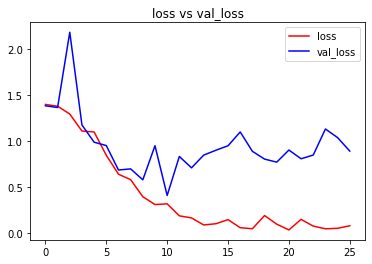

In [ ]:
plot_metric(convlstm_model_history, 'loss', 'val_loss')

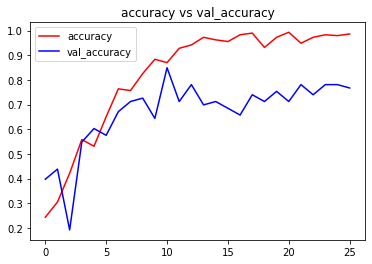

In [ ]:
plot_metric(convlstm_model_history, 'accuracy', 'val_accuracy')

In [ ]:
#Training LRCNN
def create_LRCNN_model():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(filters=16,kernel_size=(3,3), padding='same', activation='relu',
                                   input_shape=(sequence_length, image_height, image_width, 3))))
  model.add(TimeDistributed(MaxPool2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPool2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPool2D(pool_size=(4,4))))
  model.add(Dropout(0.25))

  # model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')))
  # model.add(TimeDistributed(MaxPool2D(pool_size=(4,4))))
  # model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))

  model.add(Dense(len(classes_list), activation= 'softmax'))
  model.build(input_shape=(1, sequence_length, image_height, image_width, 3))
  model.summary()

  return model


In [ ]:
LRCNN_model = create_LRCNN_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (1, 20, 64, 64, 16)      448       
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (1, 20, 16, 16, 16)      0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (1, 20, 16, 16, 16)      0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (1, 20, 16, 16, 32)      4640      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (1, 20, 4, 4, 32)       

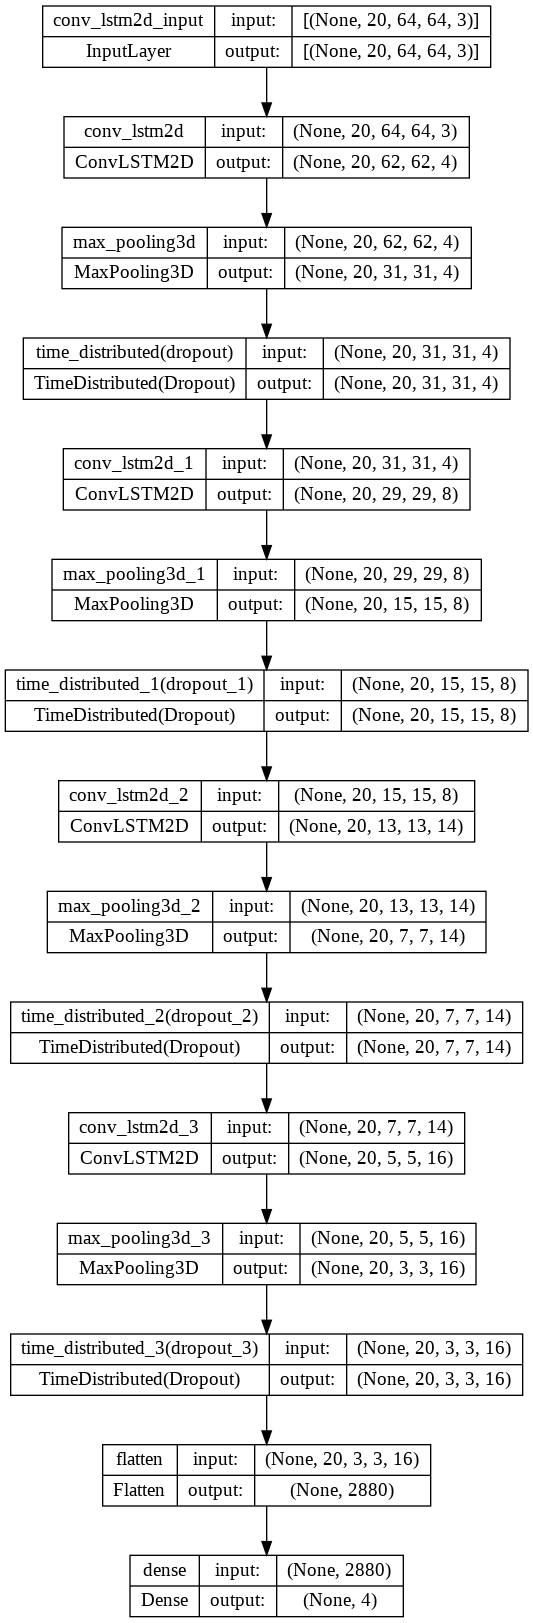

In [ ]:
plot_model(convlstm_model, to_file='/content/drive/MyDrive/FYP Studies/LRCNN_model.png', show_shapes=True)

In [ ]:
#training the LRCNN
LRCNN_early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
LRCNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
LRCNN_train_history = LRCNN_model.fit(x = features_train, y=labels_train, batch_size=4, epochs=50, validation_split=0.2, shuffle=True, callbacks=LRCNN_early_stopping)

Epoch 1/50
73/73 [==============================] - 4s 17ms/step - loss: 1.4038 - accuracy: 0.2911 - val_loss: 1.3648 - val_accuracy: 0.3836
Epoch 2/50
73/73 [==============================] - 1s 8ms/step - loss: 1.3694 - accuracy: 0.3151 - val_loss: 1.3429 - val_accuracy: 0.2466
Epoch 3/50
73/73 [==============================] - 1s 9ms/step - loss: 1.3202 - accuracy: 0.4041 - val_loss: 1.3403 - val_accuracy: 0.3014
Epoch 4/50
73/73 [==============================] - 1s 8ms/step - loss: 1.2243 - accuracy: 0.4726 - val_loss: 1.1324 - val_accuracy: 0.3836
Epoch 5/50
73/73 [==============================] - 1s 8ms/step - loss: 1.1429 - accuracy: 0.5377 - val_loss: 1.0152 - val_accuracy: 0.6301
Epoch 6/50
73/73 [==============================] - 1s 9ms/step - loss: 1.0719 - accuracy: 0.5240 - val_loss: 1.0192 - val_accuracy: 0.6438
Epoch 7/50
73/73 [==============================] - 1s 8ms/step - loss: 0.9446 - accuracy: 0.6267 - val_loss: 0.8990 - val_accuracy: 0.6164
Epoch 8/50
73/73 [=

In [ ]:
LRCNN_val_history = LRCNN_model.evaluate(x=features_test, y=labels_test)

4/4 [==============================] - 0s 66ms/step - loss: 0.4589 - accuracy: 0.8607


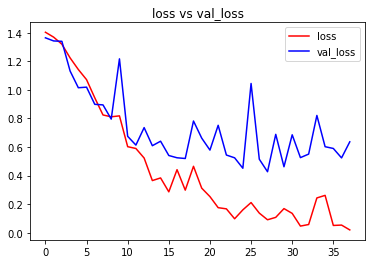

In [ ]:
#visualize the model
plot_metric(LRCNN_train_history, 'loss', 'val_loss')

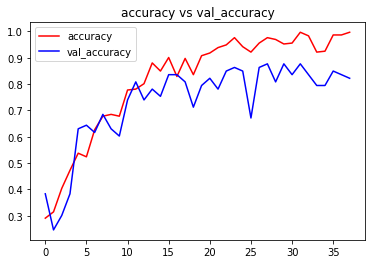

In [ ]:
# plot_metric(LRCNN_val_history, 'accuracy', 'val_accuracy')
plot_metric(LRCNN_train_history, 'accuracy', 'val_accuracy')

In [ ]:
#saving the model
current_data_time = dt.datetime.now()
time_format = '%d_%m_%Y_%H_%M_%S'
formatted_date_time = strftime(time_format)
LRCNN_model.save('/content/drive/MyDrive/FYP Studies/LRCNN'+formatted_date_time+'.h5')

In [ ]:
from pytube import *
def download_video(video_url, output_dir):
 yt = YouTube(video_url)
 title = yt.title
 output_file_name = f'{output_dir}/{title}.mp4'
 mystream = yt.streams.get_highest_resolution()
 mystream.download(output_path=output_dir, filename=output_file_name)
 return title

In [ ]:
url = 'https://youtu.be/g0LkJ2bv1rg'
output_dir = '/content/drive/MyDrive/FYP Studies/test_video'

os.makedirs(output_dir, exist_ok=True)
video_title = download_video(url, output_dir)

In [ ]:
def predict_on_video(video_file_path, output_file_path, sequence):
  video_reader = cv2.VideoCapture(video_file_path)
  frame_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frame_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

  return frame_height, frame_width